<a href="https://colab.research.google.com/github/tronghieu2810/DEEP-LEARNING/blob/main/UDEMY/%5BMike_X_Cohen%5D_Deep_understanding/styletransfer/DUDL_style_codeChallengeAlexNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as T

# To read an image from a url
from imageio import imread

import numpy as np
# for data visualization
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')

# Import AlexNet and freeze all layers

In [2]:
# Import the model
alex_net = torchvision.models.alexnet(pretrained=True)

# Freeze all layers
for p in alex_net.parameters():
    p.requires_grad = False

# Set to evaluation mode
alex_net.eval()

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [3]:
# send the network to the GPU if available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

alex_net.to(device);

# Import two images

In [6]:
img_4_content = imread('https://upload.wikimedia.org/wikipedia/commons/6/61/De_nieuwe_vleugel_van_het_Stedelijk_Museum_Amsterdam.jpg')
img_4_style   = imread('https://upload.wikimedia.org/wikipedia/commons/c/c5/Edvard_Munch%2C_1893%2C_The_Scream%2C_oil%2C_tempera_and_pastel_on_cardboard%2C_91_x_73_cm%2C_National_Gallery_of_Norway.jpg')

# Initialize the target image and random numbers
img_4_target = np.random.randint(low=0, high=255, size=img_4_content.shape, dtype=np.uint8)

print(img_4_content.shape)
print(img_4_target .shape)
print(img_4_style  .shape)

(1675, 3000, 3)
(1675, 3000, 3)
(4000, 3223, 3)


In [7]:
# Create the transform
Ts = T.Compose([T.ToTensor(),
                T.Resize(256),
                T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

# Apply to the images ("unsqueeze" to make them a 4D tensor) and push to GPU
img_4_content = Ts(img_4_content).unsqueeze(0).to(device)
img_4_style   = Ts(img_4_style)  .unsqueeze(0).to(device)
img_4_target  = Ts(img_4_target) .unsqueeze(0).to(device)

print(img_4_content.shape)
print(img_4_target .shape)
print(img_4_style  .shape)

torch.Size([1, 3, 256, 458])
torch.Size([1, 3, 256, 458])
torch.Size([1, 3, 317, 256])


Text(0.5, 1.0, 'Style picture')

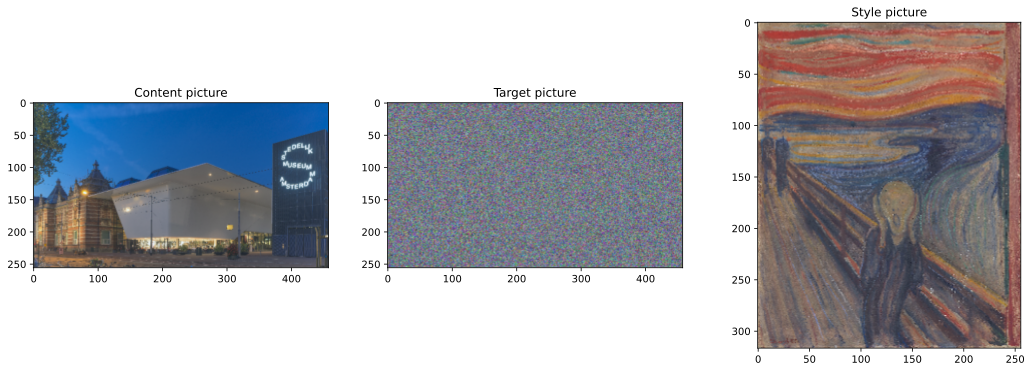

In [8]:
# "Before" pics
fig, ax = plt.subplots(1, 3, figsize=(18, 6))

pic = img_4_content.cpu().squeeze().numpy().transpose((1, 2, 0))
pic = (pic - np.min(pic)) / (np.max(pic) - np.min(pic))
ax[0].imshow(pic)
ax[0].set_title('Content picture')

pic = img_4_target.cpu().squeeze().numpy().transpose((1, 2, 0))
pic = (pic - np.min(pic)) / (np.max(pic) - np.min(pic))
ax[1].imshow(pic)
ax[1].set_title('Target picture')

pic = img_4_style.cpu().squeeze().numpy().transpose((1, 2, 0))
pic = (pic - np.min(pic)) / (np.max(pic) - np.min(pic))
ax[2].imshow(pic)
ax[2].set_title('Style picture')

# Functions to extract image feature map activations

In [9]:
def get_feature_map_acts(img, net):
    """ Function returning feature maps """

    # Initialize Feature maps as a list
    feature_maps   = []
    feature_names  = []
    conv_layer_idx = 0

    # Loop through all layers in the "features" block
    for layer_num in range(len(net.features)):
        # Print out info from this layer
        # print(layer_num, net.features[layer_num])

        # Process the image through this layer
        img = net.features[layer_num](img)

        # Store the image if it's a conv2d layer
        if ('Conv2d' in str(net.features[layer_num])):
            feature_maps .append(img)
            feature_names.append(f'ConvLayer_{conv_layer_idx}')
            conv_layer_idx += 1
        
    return feature_maps, feature_names

In [10]:
def gram_matrix(M):
    """ Returns the Gram matrix of the feature activation map """
    # Reshape to 2D
    _, chans, height, width = M.shape
    M = M.reshape(chans, height * width)

    # Compute and return covariance matrix
    gram = torch.mm(M, M.t()) / (chans * height * width)

    return gram

In [12]:
content_feature_maps, content_feature_names = get_feature_map_acts(img_4_content, alex_net)
style_feature_maps, style_feature_names     = get_feature_map_acts(img_4_style,   alex_net)

# Now for the transfer

In [11]:
# Layers to use
layers_4_content = ['ConvLayer_1']
layers_4_style   = ['ConvLayer_0', 'ConvLayer_1', 'ConvLayer_2', 'ConvLayer_3', 'ConvLayer_4']
weights_4_style  = [     1,             0.8,           0.6,          0.4,            0.2     ] 

In [13]:
# Make a copy of the target image and push to GPU
target = img_4_target.clone()
target.requires_grad = True
target = target.to(device)
style_scaling = 5e4

# Number of epochs to train
num_epochs = 1500

# Optimizer for backprop
optimizer = torch.optim.RMSprop([target], lr=0.001)

for epoch_i in range(num_epochs):
    # Extract the target feature maps
    target_feature_maps, target_feature_names = get_feature_map_acts(target, alex_net)

    # Initialize the individual loss components
    style_loss   = 0
    content_loss = 0

    # Loop over layers
    for layer_i in range(len(target_feature_names)):

        # Compute the content loss
        if (target_feature_names[layer_i] in layers_4_content):
            content_loss += torch.mean((target_feature_maps[layer_i] - content_feature_maps[layer_i]) ** 2)

        # Compute the style loss
        if (target_feature_names[layer_i] in layers_4_style):

            # Gram matrix
            G_target = gram_matrix(target_feature_maps[layer_i])
            G_style  = gram_matrix(style_feature_maps [layer_i])

            # Compute their loss
            style_loss += torch.mean((G_target - G_style) ** 2) * weights_4_style[layers_4_style.index(target_feature_names[layer_i])]

    # Combined loss
    combi_loss = style_scaling * style_loss + content_loss

    # Backprop
    optimizer.zero_grad()
    combi_loss.backward()
    optimizer.step()

# Let's have a looksie!

[]

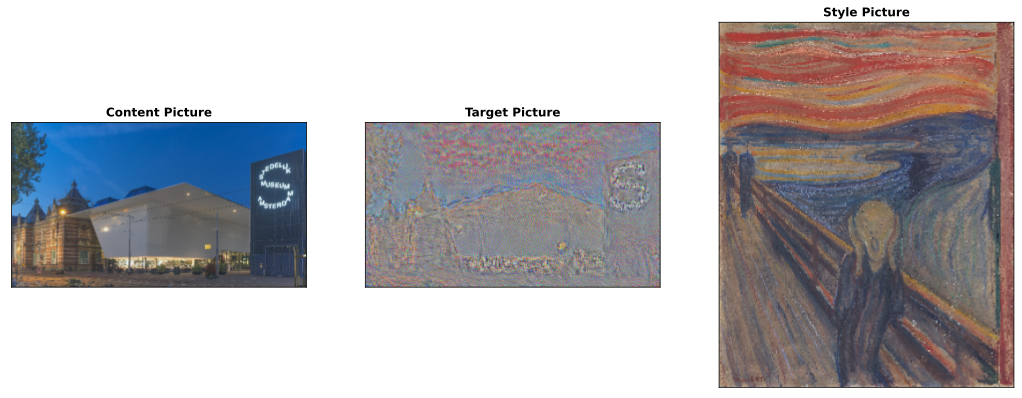

In [14]:
# The "after" pic
fig, ax = plt.subplots(1, 3, figsize=(18, 11))

pic = img_4_content.cpu().squeeze().numpy().transpose((1, 2, 0))
pic = (pic - np.min(pic)) / (np.max(pic) - np.min(pic))
ax[0].imshow(pic)
ax[0].set_title('Content Picture', fontweight='bold')
ax[0].set_xticks([])
ax[0].set_yticks([])

pic = torch.sigmoid(target).cpu().detach().squeeze().numpy().transpose((1, 2, 0))
ax[1].imshow(pic)
ax[1].set_title('Target Picture', fontweight='bold')
ax[1].set_xticks([])
ax[1].set_yticks([])

pic = img_4_style.cpu().squeeze().numpy().transpose((1, 2, 0))
pic = (pic - np.min(pic)) / (np.max(pic) - np.min(pic))
ax[2].imshow(pic)
ax[2].set_title('Style Picture', fontweight='bold')
ax[2].set_xticks([])
ax[2].set_yticks([])